# TomoPy test 02
#### Reconstruction of small TOMCAT dataset with phase retrieval <br />
Author: [Gianluca Iori](mailto:gianthk.iori@gmail.com)<br />
Created on: 06-11-2020 <br />
Modified on: 23-02-2021 <br />

see also:
https://tomopy.readthedocs.io/en/latest/ipynb/tomopy.html

#### Activate TomoPy kernel in Jupyter:
`conda env list`

`source activate tomopy`

`python -m ipykernel install --user --name tomopy_source --display-name "conda (tomopy_source)"`

`jupyter notebook &`

In [12]:
%%html
<style>
table {float:left}
</style>

In [1]:
import os
import dxchange
import tomopy
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt

astropy module not found


In [2]:
matplotlib.rcParams['figure.dpi'] = 150

In [3]:
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
h5file = "/home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5"
path_recon = "/home/gianthk/Data/StefanFly_test/test_00_/recon_phase/"

#### Read TOMCAT HDF5 data
- The `.read_aps_32id()` method of DXchange can read TOMCAT .h5 data
- If run without arguments (proj..), the import seem to be virtual (mem map)? I don't see this data in the RAM and I can reconstruct the whole volume on my laptop

In [5]:
# read the full proj
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0)

INFO:dxchange.reader:Data successfully imported: /home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5
INFO:dxchange.reader:Data successfully imported: /home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5
INFO:dxchange.reader:Data successfully imported: /home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5
INFO:dxchange.reader:Data successfully imported: /home/gianthk/Data/StefanFly_test/test_00_/test_00_.h5


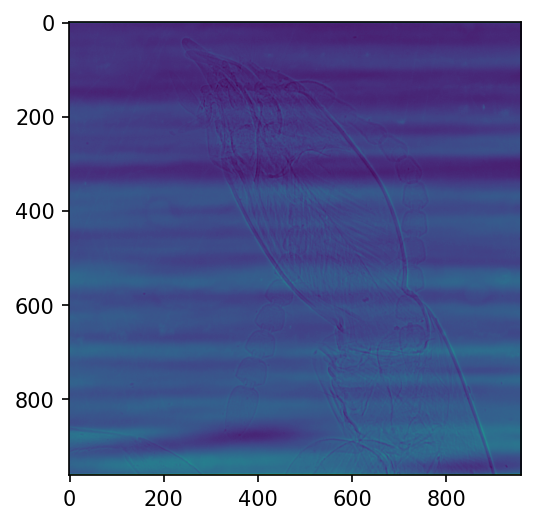

In [6]:
plt.imshow(projs[200, :, :])
plt.show()

If the angular information is not avaialable from the raw data you need to set the data collection angles. In this case, theta is set as equally spaced between 0-180 degrees.

In [7]:
if theta is None:
    theta = tomopy.angles(projs.shape[0])

#### Flat field correction

In [8]:
projs = tomopy.normalize(projs, flats, darks)

#### Phase retrieval

In [9]:
projs_phase = tomopy.retrieve_phase(projs, pixel_size=1e-4*(6.5/4), dist=30, energy=22, alpha=1e-3, pad=True, ncore=None, nchunk=None)

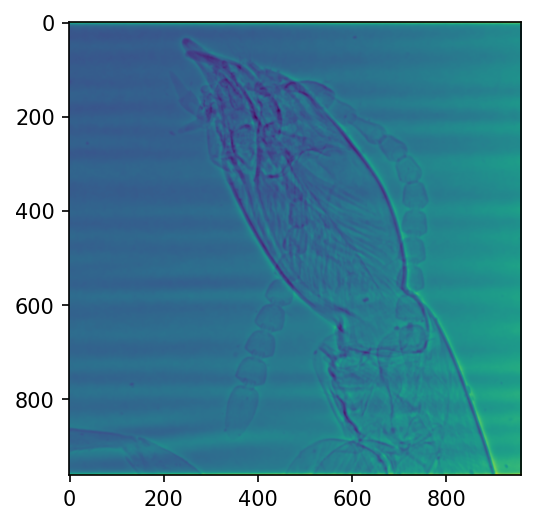

In [10]:
plt.imshow(projs_phase[200, :, :])
plt.show()

#### Automatic detect Center Of Rotation (COR)

In [11]:
COR = tomopy.find_center(projs_phase, theta, init=projs.shape[2]/2, ind=200, tol=0.5)
print(COR)

Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Trying rotation center: [480.]
INFO:tomopy.recon.rotation:Function value = 1.313041
INFO:tomopy.recon.rotation:Trying rotation center: [504.]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.340650
INFO:tomopy.recon.rotation:Trying rotation center: [456.]
INFO:tomopy.recon.rotation:Function value = 1.338269
INFO:tomopy.recon.rotation:Trying rotation center: [468.]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.316500
INFO:tomopy.recon.rotation:Trying rotation center: [492.]
INFO:tomopy.recon.rotation:Function value = 1.316394
INFO:tomopy.recon.rotation:Trying rotation center: [486.]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.304348
INFO:tomopy.recon.rotation:Trying rotation center: [492.]
INFO:tomopy.recon.rotation:Function value = 1.316394
INFO:tomopy.recon.rotation:Trying rotation center: [483.]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.305533
INFO:tomopy.recon.rotation:Trying rotation center: [489.]
INFO:tomopy.recon.rotation:Function value = 1.309614
INFO:tomopy.recon.rotation:Trying rotation center: [484.5]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.304251
INFO:tomopy.recon.rotation:Trying rotation center: [483.]
INFO:tomopy.recon.rotation:Function value = 1.305533
INFO:tomopy.recon.rotation:Trying rotation center: [485.25]


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...


INFO:tomopy.recon.rotation:Function value = 1.304059
INFO:tomopy.recon.rotation:Trying rotation center: [486.]
INFO:tomopy.recon.rotation:Function value = 1.304348
INFO:tomopy.recon.rotation:Trying rotation center: [484.875]
INFO:tomopy.recon.rotation:Function value = 1.303397


Reconstructing 1 slice groups with 1 master threads...
Reconstructing 1 slice groups with 1 master threads...
[484.875]


#### Reconstruction with CPU
|       |  |
| :---------- | :---------- |
| **Algorithm**      | `gridrec` |
| **COR**   | Auto COR from step above seems to have an offset |


In [19]:
recon = tomopy.recon(projs_phase, theta, center=COR, algorithm='gridrec', sinogram_order=False)

Reconstructing 8 slice groups with 8 master threads...


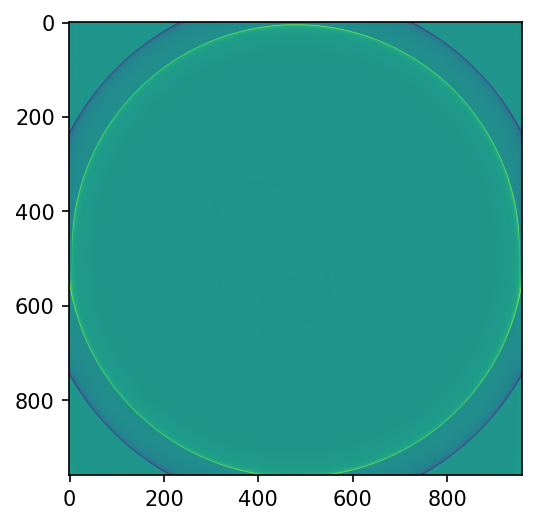

In [20]:
plt.imshow(recon[200, :, :])
plt.show()

#### Apply circular mask

In [21]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, val=0)

Visualize results

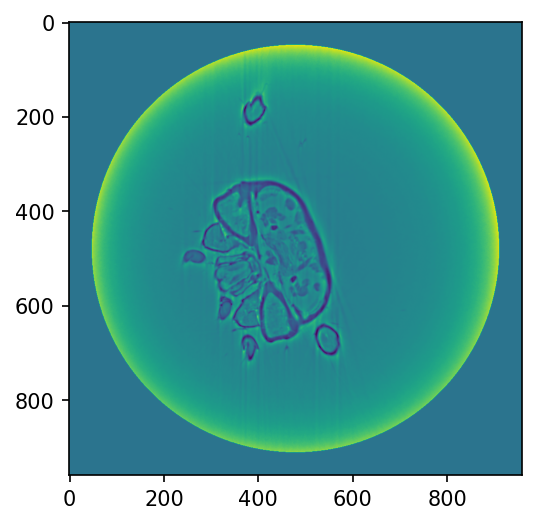

In [22]:
plt.imshow(recon[200, :, :])
plt.show()

#### Scale to 0-255 (`uint8`)
The uint8 GV range for output slices can cover the full float32 range or be selected based on the 3D data histogram

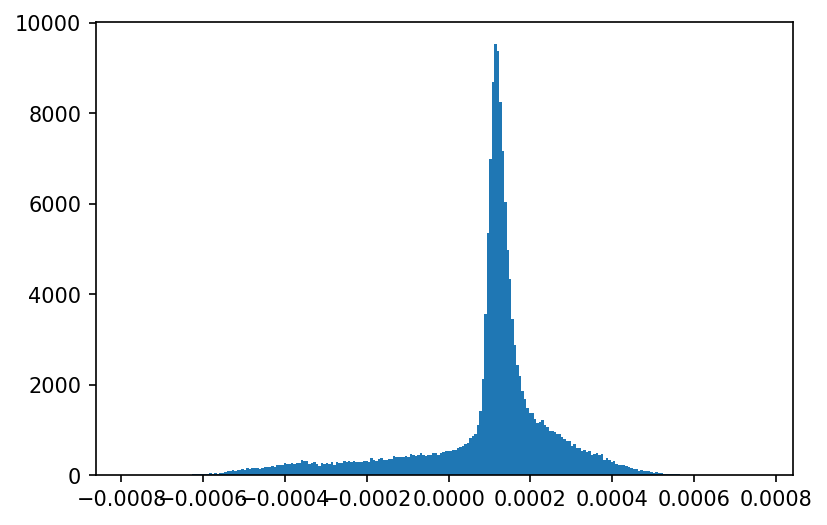

In [45]:
plt.hist(recon[200,300:700,300:700].ravel(), bins=256)
plt.show()

In [46]:
# uint8 GV range as MIN and MAX of 3D data
range_min = 1.1*np.min(recon[200,300:700,300:700])
range_max = 1.1*np.max(recon[200,300:700,300:700])
range_max = range_max - range_min

In [53]:
recon_uint8Range = 255*((recon - range_min)/range_max)

In [54]:
recon_uint8Range[recon_uint8Range < 0] = 0

In [55]:
recon_uint8Range[recon_uint8Range > 255] = 255

In [51]:
# apply again circ mask
recon_uint8Range = tomopy.circ_mask(recon_uint8Range, axis=0, ratio=0.95)

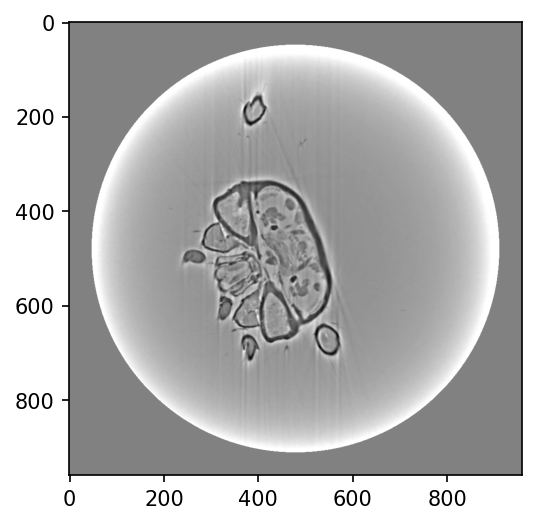

In [56]:
plt.imshow(recon_uint8Range[200, :, :], cmap='gray')
plt.show()

#### Write output Tiff stack as `uint8`

In [58]:
fileout = path_recon+'data.tiff'
# dxchange.writer.write_tiff_stack(recon, fname=fileout, axis=0, digit=5, start=0, overwrite=True)
dxchange.writer.write_tiff_stack(recon_uint8Range, fname=fileout, dtype='uint8', axis=0, digit=5, start=0, overwrite=True)